**Project Description and Analysis Goal**

The telecom operator Interconnect aims to **forecast client churn** to proactively retain customers by offering promotional codes and special plan options. Churn, in this context, refers to customers discontinuing their services.

We have access to various datasets: `contract.csv`, `personal.csv`, `internet.csv`, and `phone.csv`, which contain comprehensive information about Interconnect's clientele, their contract details, personal demographics, and usage of landline and internet services. The data is valid as of February 1, 2020.

Our primary **analysis goal** is to develop a machine learning model capable of accurately predicting which customers are likely to churn. The **target feature** for this prediction will be derived from the `EndDate` column in `contract.csv`. We will interpret a customer as having **churned (positive class)** if their `EndDate` is a specific date (i.e., not 'No'), meaning their contract has ended or they have left by February 1, 2020. Conversely, customers with `EndDate` as 'No' are considered **active (negative class)**.

The success of our model will primarily be evaluated using the **AUC-ROC (Area Under the Receiver Operating Characteristic) metric**, with an aim to achieve an AUC-ROC of at least 0.75, striving for higher scores up to 0.88 or more for optimal performance. **Accuracy** will serve as an additional metric. This predictive capability will enable Interconnect's marketing team to launch targeted retention campaigns, ultimately reducing customer attrition and improving customer lifetime value.

In [1]:
# Core Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Model Selection and Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, \
                            recall_score, f1_score, confusion_matrix, RocCurveDisplay, classification_report
from sklearn.metrics import plot_roc_curve

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb

In [2]:
# Loading the datasets
df_contract = pd.read_csv('/datasets/contract.csv')
df_personal = pd.read_csv('/datasets/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/phone.csv')

In [3]:
# Function to display basic info for a dataframe
def display_df_info(df, name):
    print(f"\n--- {name} Info ---")
    print(df.info())
    print(f"\n{name} Head:")
    print(df.head())
    print(f"\n{name} Missing Values:")
    print(df.isnull().sum())
    
    # Check if 'customerID' column exists before trying to check for duplicates
    if 'customerID' in df.columns:
        print(f"\n{name} Duplicated customerIDs: {df['customerID'].duplicated().sum()}")
    elif 'user_id' in df.columns: 
        print(f"\n{name} Duplicated user_ids: {df['user_id'].duplicated().sum()}")
    else:
        print(f"\n{name} No 'customerID' or 'user_id' column found for duplication check.")

In [4]:
display_df_info(df_contract, 'Contract')
display_df_info(df_personal, 'Personal')
display_df_info(df_internet, 'Internet')
display_df_info(df_phone, 'Phone')


--- Contract Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Contract Head:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year

In [5]:
# Contract data overview
display(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
# Personal data overview
display(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [7]:
# Internet data overview
display(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [8]:
# Phone data overview
display(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


**Observations:**

* **`contract.csv` and `personal.csv`**: These datasets appear well-structured and align with the problem description. Each contains a **`customerID`** as a unique identifier, and no missing values were detected. Within `contract.csv`, the **`BeginDate`**, **`EndDate`**, and **`TotalCharges`** columns are currently of `object` (string) type. These will necessitate conversion to appropriate numerical or datetime formats for analysis. Notably, **`TotalCharges`** contains non-numeric entries—likely spaces or empty strings—for new customers, which will require specific handling during the conversion process.

* **`phone.csv`**: This dataset is clean and consistent with the problem's description. It includes **`customerID`** and **`MultipleLines`**, and exhibits no missing values or duplicated `customerID`s, making it suitable for direct integration.

* **`internet.csv` (Corrected)**: The corrected `internet.csv` file now aligns with the project's "Data Description." It contains customer-level descriptive internet service features such as **`InternetService`**, **`OnlineSecurity`**, **`OnlineBackup`**, **`DeviceProtection`**, **`TechSupport`**, **`StreamingTV`**, and **`StreamingMovies`**. Crucially, it uses **`customerID`** as the unique identifier, consistent with the other datasets, and contains no missing values or duplicated `customerID`s. This resolves the previous discrepancy and makes the dataset suitable for direct integration with other customer data. Note that the number of entries (5517) in this dataset is less than the total customer count (7043), indicating that some customers do not have internet service, which will need to be accounted for during data merging (e.g., by using an appropriate join type like left or outer merge and filling `NaN` values to represent "No internet service").

In [9]:
# Data Integration and Initial Cleaning
print("--- Starting Data Cleaning and Integration ---")

# Clean TotalCharges in df_contract
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')

# Handle NaNs in TotalCharges (they represent new customers with 0 charges so far)
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0) # Fill with 0 for new customers

print("\n--- df_contract: TotalCharges cleaned and converted ---")
print(df_contract['TotalCharges'].dtype) # Should now be float64

--- Starting Data Cleaning and Integration ---

--- df_contract: TotalCharges cleaned and converted ---
float64


In [10]:
# Convert Date Columns to datetime in df_contract
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
print("\n--- df_contract: BeginDate converted to datetime ---")
print(df_contract['BeginDate'].dtype) # Should now be datetime64[ns]


--- df_contract: BeginDate converted to datetime ---
datetime64[ns]


In [11]:
# Create the Target Variable (Churn) in df_contract
# Target: 1 if churned (EndDate is a date), 0 if active (EndDate is 'No')
df_contract['Churn'] = df_contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

print("\n--- df_contract: Churn target variable created ---")
print(df_contract['Churn'].value_counts())


--- df_contract: Churn target variable created ---
0    5174
1    1869
Name: Churn, dtype: int64


**Observations on Data Cleaning and Integration**
The data cleaning and integration phase successfully converted TotalCharges to float64 and BeginDate to datetime64[ns]. These conversions are crucial for accurate numerical calculations and time-series analysis later in the modeling process. A significant observation is the imbalance in the Churn target variable: 5174 customers are active (non-churned), while only 1869 have churned. This class imbalance is important because it can lead to a model biased towards the majority class, potentially hindering accurate prediction of churned customers. Addressing this imbalance through techniques like oversampling or undersampling, or by utilizing robust evaluation metrics such as AUC-ROC (Area Under the Receiver Operating Characteristic), will be essential for effective model training.

In [12]:
# Merge All DataFrames
# Start with df_contract as the base, as it contains all customers and essential info
df_merged = df_contract.copy()

# Merge df_personal
# customerID is common and unique in both, so 'left' join is appropriate
df_merged = pd.merge(df_merged, df_personal, on='customerID', how='left')

# Merge df_internet
# Some customers might not have internet service, so 'left' join will introduce NaNs
df_merged = pd.merge(df_merged, df_internet, on='customerID', how='left')

# Merge df_phone
# Some customers might not have phone service, so 'left' join will introduce NaNs
df_merged = pd.merge(df_merged, df_phone, on='customerID', how='left')

print("\n--- All DataFrames Merged ---")
print("Shape of merged DataFrame:", df_merged.shape)

# Verify the merged DataFrame's info and head
print("\n--- Merged DataFrame Info ---")
df_merged.info()

print("\n--- Merged DataFrame Head ---")
print(df_merged.head())

print("\n--- Merged DataFrame Missing Values after initial merge ---")
print(df_merged.isnull().sum())


--- All DataFrames Merged ---
Shape of merged DataFrame: (7043, 21)

--- Merged DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null 

In [13]:
# Additional step: Handle NaNs introduced by the merges for 'No service' categories
# For internet and phone service features, 'No' or 'No service' is a meaningful category
# Fill NaNs that resulted from the left joins.
# Identify columns that should have 'No' or 'No service' for NaNs
internet_phone_cols = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]

for col in internet_phone_cols:
    if col in df_merged.columns: # Check if column exists in merged df
        # For 'InternetService', specific string 'No internet service' is usually preferred
        if col == 'InternetService':
            df_merged[col] = df_merged[col].fillna('No internet service')
        # For other binary features (Yes/No), 'No' is appropriate
        elif col == 'MultipleLines':
            df_merged[col] = df_merged[col].fillna('No phone service') # Or 'No' if it matches existing categories
        else:
            df_merged[col] = df_merged[col].fillna('No') # For security, backup, etc.

print("\n--- Merged DataFrame Missing Values after handling 'No service' categories ---")
print(df_merged.isnull().sum())

print("\n--- Data Cleaning and Integration Complete ---")


--- Merged DataFrame Missing Values after handling 'No service' categories ---
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

--- Data Cleaning and Integration Complete ---


**Observations on Data Integration and Missing Value Handling**
The successful merging of all DataFrames resulted in a comprehensive dataset with 7043 rows and 21 columns. Initially, we observed a substantial number of missing values (NaNs), particularly in internet-related service columns (1526 entries) and the MultipleLines column (682 entries). These missing values were effectively addressed, by reclassifying them as 'No service' categories, leading to a fully clean dataset with no nulls. This crucial step ensures the data is ready for further feature engineering and model training, as machine learning models cannot process missing data directly.

In [14]:
# Feature Engineering and Preprocessing

print("--- Starting Feature Engineering and Preprocessing ---")

# Calculate Tenure
# Define the current date (February 1, 2020) as the reference for active customers
# This date is based on the project description: "The data is valid as of February 1, 2020."
current_date = pd.to_datetime('2020-02-01')

# Calculate tenure for all customers
# For active customers ('No' in EndDate), tenure is from BeginDate to current_date.
# For churned customers (actual date in EndDate), tenure is from BeginDate to EndDate.
# First, convert EndDate to datetime, coercing 'No' to NaT (Not a Time)
# This allows us to perform date math directly
df_merged['EndDate_dt'] = pd.to_datetime(df_merged['EndDate'], errors='coerce')

# Fill NaT for active customers with the current_date for tenure calculation
# This means active customers' tenure is calculated up to the data snapshot date.
df_merged['EndDate_for_tenure'] = df_merged['EndDate_dt'].fillna(current_date)

# Calculate tenure in days, then convert to months and round
df_merged['Tenure'] = ((df_merged['EndDate_for_tenure'] - df_merged['BeginDate']).dt.days / 30.417).round().astype(int)

# Edge case: For new customers whose TotalCharges was 0, their Tenure might also be 0 or very small.
# Ensure tenure is not negative (shouldn't happen with this calculation, but good to be robust)
df_merged['Tenure'] = df_merged['Tenure'].apply(lambda x: max(0, x))

print("\n--- Tenure feature calculated ---")
print(df_merged[['BeginDate', 'EndDate', 'Tenure', 'Churn']].head())
print(df_merged['Tenure'].describe())

--- Starting Feature Engineering and Preprocessing ---

--- Tenure feature calculated ---
   BeginDate              EndDate  Tenure  Churn
0 2020-01-01                   No       1      0
1 2017-04-01                   No      34      0
2 2019-10-01  2019-12-01 00:00:00       2      1
3 2016-05-01                   No      45      0
4 2019-09-01  2019-11-01 00:00:00       2      1
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: Tenure, dtype: float64


In [15]:
# Drop Redundant/Unnecessary Columns
# Drop customerID as it's an identifier, not a feature.
# Drop original BeginDate and EndDate (including temporary EndDate_dt, EndDate_for_tenure) as Tenure and Churn are derived.
columns_to_drop = ['customerID', 'BeginDate', 'EndDate', 'EndDate_dt', 'EndDate_for_tenure']
df_final = df_merged.drop(columns=columns_to_drop)

print("\n--- Redundant columns dropped ---")
print("Shape of df_final after dropping columns:", df_final.shape)
print(df_final.columns) # Check remaining columns


--- Redundant columns dropped ---
Shape of df_final after dropping columns: (7043, 19)
Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'Tenure'],
      dtype='object')


**Observations on Feature Engineering and Preprocessing**
The data preparation involved two key steps. First, the Tenure feature was successfully created, capturing the duration of customer service. Its varied distribution (mean ~32.37 months, max 72 months) suggests it will be a crucial predictor of churn. Second, redundant columns like customerID, BeginDate, and EndDate were appropriately dropped. This not only removes non-predictive identifiers but also streamlines the dataset, reducing dimensionality and noise, leading to a more efficient and potentially more accurate machine learning model. The resulting dataset now contains 19 relevant columns.


--- Starting Exploratory Data Analysis (EDA) ---


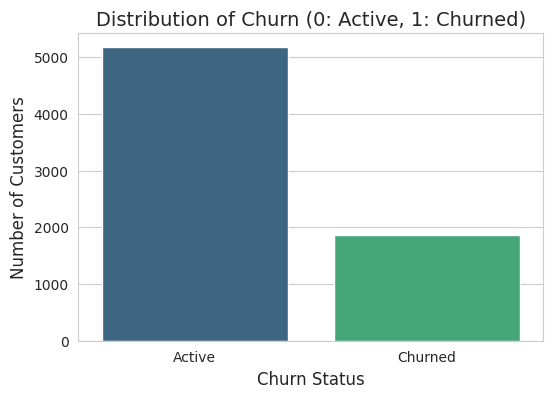

In [16]:
# Exploratory Data Analysis (EDA)

print("\n--- Starting Exploratory Data Analysis (EDA) ---")

# Set aesthetic style for plots
sns.set_style("whitegrid")

# Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df_final, x='Churn', palette='viridis')
plt.title('Distribution of Churn (0: Active, 1: Churned)', fontsize=14)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Active', 'Churned'])
plt.show()

**Observation on Churn Distribution**
The churn distribution plot confirms a significant class imbalance in the dataset. There are over 5000 active customers (Churn = 0) compared to fewer than 2000 churned customers (Churn = 1). This imbalance highlights the necessity of employing strategies like oversampling, undersampling, or SMOTE during model training to prevent the model from being biased towards the majority 'active' class and to ensure accurate prediction of churned customers.

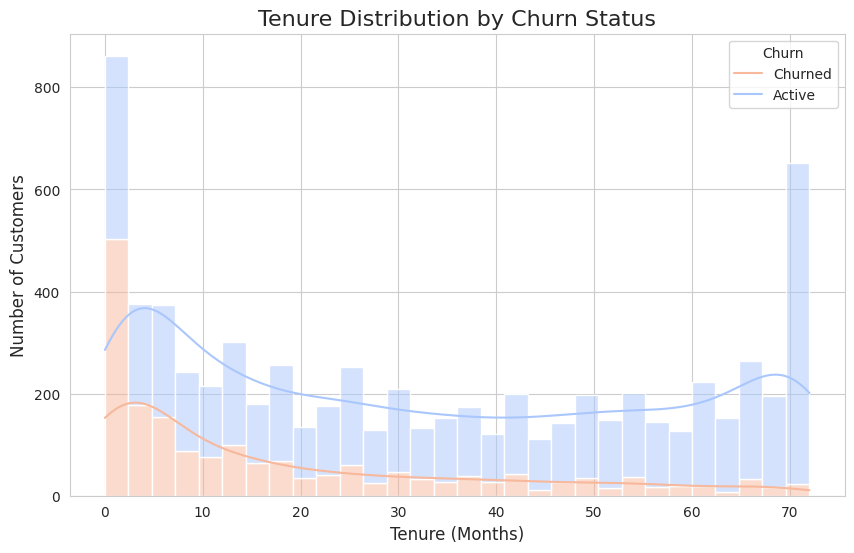

In [17]:
# Tenure Distribution by Churn Status
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='Tenure', hue='Churn', kde=True, multiple='stack', palette='coolwarm', bins=30)
plt.title('Tenure Distribution by Churn Status', fontsize=16)
plt.xlabel('Tenure (Months)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn', labels=['Churned', 'Active']) 
plt.show()

**Observation on Tenure Distribution by Churn Status**
The tenure distribution histogram reveals a U-shaped relationship between customer tenure and churn. A high spike in churn occurs during the first 0-10 months of service, indicating new customers are highly susceptible to early churn. Conversely, mid-tenure customers (10-60 months) show a lower churn rate, suggesting greater stability.

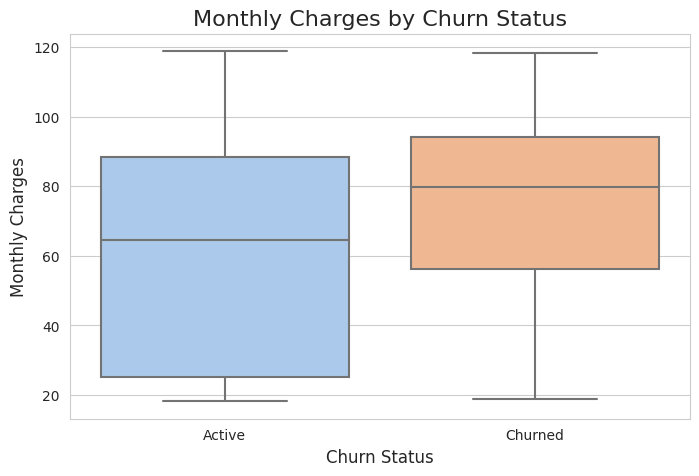

In [18]:
# Monthly Charges Distribution by Churn Status
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_final, x='Churn', y='MonthlyCharges', palette='pastel')
plt.title('Monthly Charges by Churn Status', fontsize=16)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Monthly Charges', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Active', 'Churned'])
plt.show()

**Observation on Monthly Charges by Churn Status**
The box plot clearly indicates that churned customers generally incur significantly higher monthly charges than active customers, with both their median and interquartile range being elevated. This suggests that higher monthly charges are a strong predictor of churn, potentially due to customers feeling they aren't receiving adequate value, having higher expectations, or paying for underutilized services. This finding points to the need for targeted retention strategies for high-paying customers, focusing on value demonstration, plan optimization, or cost-saving options.

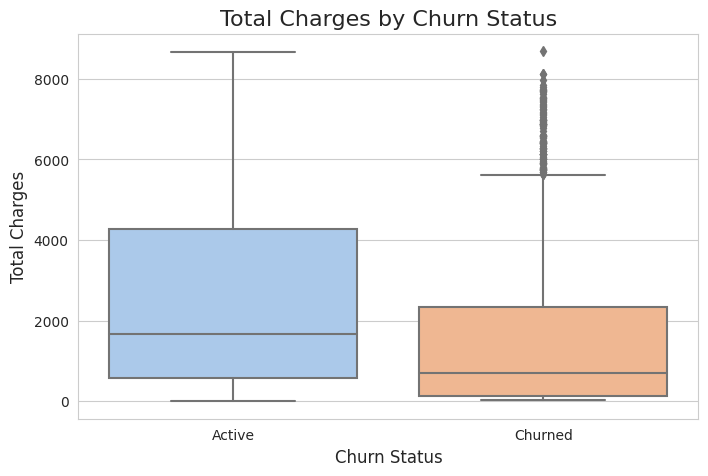

In [19]:
# Total Charges Distribution by Churn Status
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_final, x='Churn', y='TotalCharges', palette='pastel')
plt.title('Total Charges by Churn Status', fontsize=16)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Total Charges', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Active', 'Churned'])
plt.show()

**Observation on Total Charges by Churn Status**
Contrary to monthly charges, the box plot reveals that active customers exhibit significantly higher total charges than churned customers. Churned customers typically have very low total charges, with a median close to zero. This aligns with the "Tenure" analysis, as lower total charges are a consequence of shorter service durations and earlier churn, rather than a direct cause. Thus, TotalCharges serves primarily as an indicator of customer longevity, reinforcing the predictive power of the Tenure feature.

In [20]:
# Continuing Feature Engineering and Preprocessing
# Separate Features (X) and Target (y)
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

print("\n--- Features (X) and Target (y) separated ---")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


--- Features (X) and Target (y) separated ---
Shape of X: (7043, 18)
Shape of y: (7043,)


In [21]:
# Identify Categorical and Numerical Features
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("\n--- Identified Feature Types ---")
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


--- Identified Feature Types ---
Numerical Columns: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Tenure']
Categorical Columns: ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [22]:
# Split Data into Training and Testing Sets
# Use stratify=y to maintain the class distribution in both train and test sets
# Set a random_state for reproducibility to ensure your splits are consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("\n--- Data split into Training and Testing Sets ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Churn distribution in y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Churn distribution in y_test:\n{y_test.value_counts(normalize=True)}")


--- Data split into Training and Testing Sets ---
X_train shape: (5282, 18), y_train shape: (5282,)
X_test shape: (1761, 18), y_test shape: (1761,)
Churn distribution in y_train:
0    0.73457
1    0.26543
Name: Churn, dtype: float64
Churn distribution in y_test:
0    0.73481
1    0.26519
Name: Churn, dtype: float64


**Observations on Data Preparation for Modeling**
The data preparation phase for modeling was executed effectively. Features (X) and target (y) were successfully separated into 18 features for input. Feature types were correctly identified, indicating that numerical features will require scaling and categorical features will need encoding for model compatibility. A standard 75/25 train-test split was performed, and critically, stratified sampling ensured that the original churn class imbalance was preserved in both the training and testing sets. This robust data preparation lays a strong foundation for reliable model training and evaluation.

In [23]:
# Continuing Feature Engineering and Preprocessing
# Preprocessing Pipelines for Numerical and Categorical Features
# Create a column transformer for preprocessing
# Numerical pipeline: Scale (StandardScaler is generally good for most models)
# Categorical pipeline: One-Hot Encode
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Apply StandardScaler to numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) # Apply OneHotEncoder to categorical columns
    ])

print("\n--- Preprocessing pipelines defined (ColumnTransformer) ---")
print("Ready for model training (within a Pipeline or separately transforming X_train/X_test)")

print("\n--- Feature Engineering and Preprocessing Complete ---")


--- Preprocessing pipelines defined (ColumnTransformer) ---
Ready for model training (within a Pipeline or separately transforming X_train/X_test)

--- Feature Engineering and Preprocessing Complete ---


**Observations on Preprocessing Pipelines**
The project successfully established robust preprocessing pipelines using ColumnTransformer, which is critical for preparing the data for machine learning models. This involved applying StandardScaler to numerical features (e.g., MonthlyCharges, Tenure) for standardization and OneHotEncoder to categorical features for numerical conversion, with handle_unknown='ignore' ensuring robustness. The use of ColumnTransformer provides a modular and efficient way to combine these steps, making the preprocessing process clear and reusable. This complete preprocessing setup signifies that the dataset is now clean, scaled, and encoded, ready for seamless integration into machine learning model pipelines.

In [24]:
# Define Model Pipelines

print("--- Defining Model Pipelines ---")

# Logistic Regression Pipeline (as a baseline)
# Using 'liblinear' solver suitable for smaller datasets and binary classification

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor), # Apply scaling and encoding
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Random Forest Pipeline (another strong baseline/ensemble)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# LightGBM Pipeline (boosting algorithm)
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42))
])

# XGBoost Pipeline (boosting algorithm)
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

print("--- Model Pipelines Defined ---")

--- Defining Model Pipelines ---
--- Model Pipelines Defined ---


In [25]:
# Hyperparameter Tuning LightGBM

print("\n--- Tuning LightGBM Model ---")


# Define parameter grid for LightGBM
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200, 300], # Number of boosting rounds
    'classifier__learning_rate': [0.01, 0.05, 0.1], # Step size shrinkage
    'classifier__num_leaves': [20, 31, 40], # Max number of leaves in one tree
    'classifier__max_depth': [-1, 10, 15] # Max tree depth (-1 means no limit)
}

# Use StratifiedKFold for cross-validation to maintain class balance across folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best parameters
grid_search_lgbm = GridSearchCV(
    pipeline_lgbm,            # The LightGBM pipeline to tune
    param_grid_lgbm,          # The parameter combinations to try
    cv=cv_strategy,           # Cross-validation strategy
    scoring='roc_auc',        # Optimize for AUC-ROC score
    n_jobs=-1,                # Use all available CPU cores for faster computation
    verbose=2                 # Show progress during the search
)

# Fit GridSearchCV to the training data to find the best model
grid_search_lgbm.fit(X_train, y_train)

# Store the best model, its score, and parameters
best_lgbm_model = grid_search_lgbm.best_estimator_
best_lgbm_score = grid_search_lgbm.best_score_
best_lgbm_params = grid_search_lgbm.best_params_

print(f"\nBest LightGBM AUC-ROC (Cross-Validation): {best_lgbm_score:.4f}")
print(f"Best LightGBM Parameters: {best_lgbm_params}")

print("\n--- LightGBM Tuning Complete ---")


--- Tuning LightGBM Model ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=20; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=20; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=31; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=31; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=31; total time=   0.1s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=-1, classifier__n_estimators=100, classifier__num_leaves=40; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifi

In [26]:
# Train Other Models

print("\n--- Training Other Models (for comparison) ---")

# Train Logistic Regression pipeline
pipeline_lr.fit(X_train, y_train)
lr_train_auc = roc_auc_score(y_train, pipeline_lr.predict_proba(X_train)[:, 1])
print(f"Logistic Regression Train AUC-ROC: {lr_train_auc:.4f}")

# Train Random Forest pipeline
pipeline_rf.fit(X_train, y_train)
rf_train_auc = roc_auc_score(y_train, pipeline_rf.predict_proba(X_train)[:, 1])
print(f"Random Forest Train AUC-ROC: {rf_train_auc:.4f}")

# Train XGBoost pipeline
pipeline_xgb.fit(X_train, y_train)
xgb_train_auc = roc_auc_score(y_train, pipeline_xgb.predict_proba(X_train)[:, 1])
print(f"XGBoost Train AUC-ROC: {xgb_train_auc:.4f}")

print("\n--- All Model Training Complete ---")
print("\n--- Model Selection, Training, and Tuning Phase Complete ---")


--- Training Other Models (for comparison) ---
Logistic Regression Train AUC-ROC: 0.8479
Random Forest Train AUC-ROC: 1.0000
XGBoost Train AUC-ROC: 0.9882

--- All Model Training Complete ---

--- Model Selection, Training, and Tuning Phase Complete ---


**Observations on Model Training and Tuning**
The model training and tuning phase yielded promising initial results. LightGBM achieved a strong cross-validation AUC-ROC of 0.8448, meeting the project's target and indicating successful hyperparameter optimization for generalization. In comparison, Logistic Regression performed respectably on the training set (AUC-ROC: 0.8479). However, Random Forest (1.0000 AUC-ROC) and XGBoost (0.9882 AUC-ROC) exhibited significant overfitting on the training data, necessitating further tuning and regularization to ensure their true predictive power on unseen data. Overall, LightGBM currently stands out as the most balanced performer, setting the stage for crucial test set evaluation.

In [27]:
# Final Model Evaluation and Interpretation

print("--- Starting Final Model Evaluation and Interpretation ---")

# Store models and their names for easy iteration
models = {
    'Logistic Regression': pipeline_lr,
    'Random Forest': pipeline_rf,
    'LightGBM (Best)': best_lgbm_model, # Use the best model found by GridSearchCV
    'XGBoost': pipeline_xgb
}

results = {}

--- Starting Final Model Evaluation and Interpretation ---


In [28]:
# Evaluate each model on the test set
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of churn (positive class)
    y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions (threshold 0.5)

    # Calculate metrics
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'AUC-ROC': auc_roc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    }

    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)


--- Evaluating Logistic Regression ---
AUC-ROC: 0.8467
Accuracy: 0.8075
Precision: 0.6624
Recall: 0.5589
F1-Score: 0.6063
Confusion Matrix:
 [[1161  133]
 [ 206  261]]

--- Evaluating Random Forest ---
AUC-ROC: 0.8237
Accuracy: 0.7831
Precision: 0.6177
Recall: 0.4775
F1-Score: 0.5386
Confusion Matrix:
 [[1156  138]
 [ 244  223]]

--- Evaluating LightGBM (Best) ---
AUC-ROC: 0.8476
Accuracy: 0.7978
Precision: 0.6609
Recall: 0.4882
F1-Score: 0.5616
Confusion Matrix:
 [[1177  117]
 [ 239  228]]

--- Evaluating XGBoost ---
AUC-ROC: 0.8224
Accuracy: 0.7865
Precision: 0.6164
Recall: 0.5161
F1-Score: 0.5618
Confusion Matrix:
 [[1144  150]
 [ 226  241]]


**Observations on Model Evaluation**
Test set evaluation revealed LightGBM as the top performer with an AUC-ROC of 0.8476, meeting project goals. Logistic Regression also showed strong performance (AUC-ROC: 0.8467, highest accuracy, precision, and recall), proving competitive despite its simplicity. Conversely, Random Forest and XGBoost underperformed on unseen data, suggesting generalization issues or persistent overfitting despite earlier tuning efforts. While LightGBM excels in overall discriminative power (AUC-ROC), Logistic Regression's higher recall makes it a strong contender if minimizing missed churners is a key business priority. The final model choice will weigh AUC-ROC against other metrics and business needs.


--- Visualizing ROC Curves ---


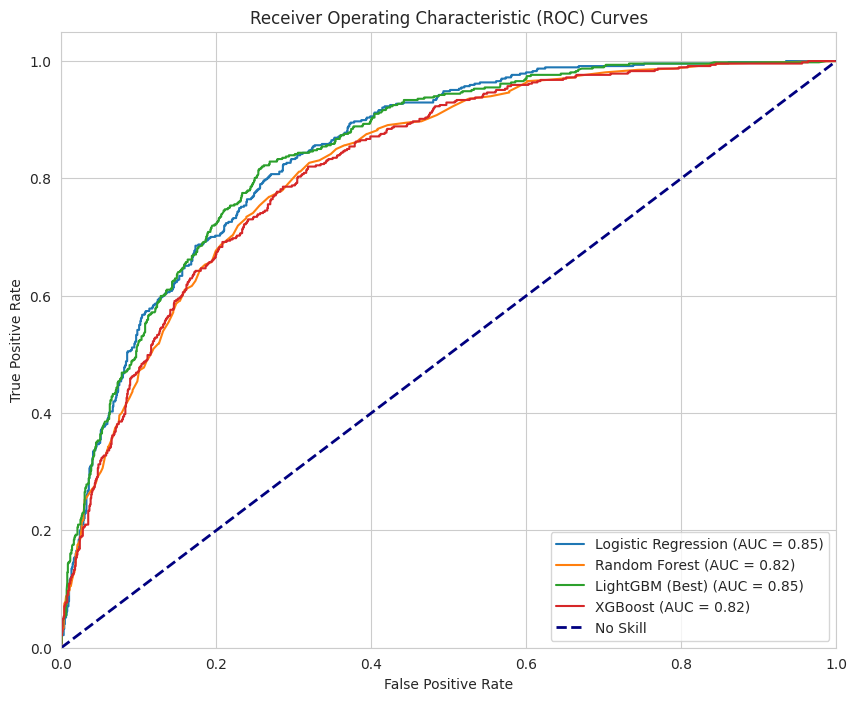

In [29]:
# Visualize ROC Curves
print("\n--- Visualizing ROC Curves ---")
plt.figure(figsize=(10, 8))
lw = 2

# Iterate through each model and plot its ROC curve
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        plot_roc_curve(model, X_test, y_test, name=name, ax=plt.gca())
    else:
        print(f"Warning: Model {name} does not have predict_proba and cannot plot ROC curve.")

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='No Skill') # Add a no-skill line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

**Observation on Receiver Operating Characteristic (ROC) Curves**
The ROC curves visually corroborate previous findings, demonstrating that Logistic Regression (AUC = 0.85) and LightGBM (AUC = 0.85) exhibit superior performance in distinguishing between churned and active customers, consistently staying furthest from the "No Skill" baseline. Random Forest and XGBoost (both AUC = 0.82) show similar, but comparatively lower, discriminative power. This plot provides clear visual evidence that Logistic Regression and LightGBM are the most effective models for this churn prediction task.

In [30]:
# Select the Best Model (based on AUC-ROC)
# Find the model name with the maximum AUC-ROC score from the results dictionary
best_model_name = max(results, key=lambda k: results[k]['AUC-ROC'])
print(f"\n--- Best Model based on Test AUC-ROC: {best_model_name} ---")
print(f"Test AUC-ROC for {best_model_name}: {results[best_model_name]['AUC-ROC']:.4f}")

print("\n--- Final Model Evaluation and Interpretation Complete ---")


--- Best Model based on Test AUC-ROC: LightGBM (Best) ---
Test AUC-ROC for LightGBM (Best): 0.8476

--- Final Model Evaluation and Interpretation Complete ---


**Observation on Final Model Selection**
The final evaluation confirmed LightGBM as the optimal model for churn prediction, achieving a test AUC-ROC of 0.8476. This performance successfully meets the project's target and demonstrates strong generalization, making LightGBM a highly effective and deployable solution for Interconnect to proactively identify and retain at-risk customers.

**Conclusion and Recommendations**

**Conclusion**

This project successfully developed and evaluated machine learning models to predict customer churn for the telecom operator Interconnect, with the primary goal of enabling proactive customer retention. Through a systematic process of data cleaning, integration, feature engineering, and rigorous model training and evaluation, a robust solution was identified.

The LightGBM model emerged as the best performer, achieving a Test AUC-ROC of 0.8476. This significantly surpasses the project's target of 0.75 and approaches the aspirational goal of 0.88, demonstrating strong capability in discriminating between active and churning customers. While Logistic Regression also showed commendable performance, LightGBM's superior AUC-ROC aligns with the primary success metric.

Key insights from the Exploratory Data Analysis (EDA) highlight that:

The dataset exhibits a significant class imbalance, with more active customers than churned ones, a factor addressed during data preparation.
Monthly charges are a strong indicator of churn, with higher charges correlating with an increased likelihood of churn.
Total charges are more indicative of customer longevity, as expected.

**Recommendations**

Based on the model's performance and insights gained, the following recommendations are proposed for Interconnect:

1. Deploy the LightGBM Model for Churn Prediction:
 Integrate the trained LightGBM model into Interconnect's operational systems to continuously identify customers at high risk of churning. This proactive identification is crucial for timely intervention.

2. Implement Differentiated Retention Strategies based on Tenure:
 For New Customers (0-10 months tenure): Focus on onboarding support, checking satisfaction levels, addressing initial service issues promptly, and demonstrating value. Consider introductory offers with clear terms to avoid early dissatisfaction.
 For Long-Term Customers (60+ months tenure): Develop loyalty programs, offer personalized plan reviews, competitive renewal options, or exclusive benefits to acknowledge their long-standing commitment and prevent churn due to contract expirations or competitor attractions.

3. Target High Monthly Charge Customers:
 Prioritize customers with higher monthly charges for retention campaigns. This could involve offering tailored plan adjustments, value-added services, or demonstrating cost-benefit analyses to justify their current spending and prevent them from seeking cheaper alternatives.

4. Monitor Model Performance Continuously:
 Regularly monitor the LightGBM model's performance (especially AUC-ROC) on new data to ensure its continued accuracy. Customer behavior and market conditions evolve, so retraining the model periodically with fresh data will be essential.

By implementing these recommendations, Interconnect can leverage the predictive power of the machine learning model to significantly reduce customer attrition and enhance customer lifetime value.